In [1]:
import pandas as pd
import pickle
from scipy import spatial
from scipy import stats
import matplotlib.pyplot as plt


def load_df(path):
    df = pd.read_csv(path)
    return df

def get_distance(point1, point2):
    return spatial.distance.cosine(point1, point2)

def to_floats(vector_str):
    return [float(s) for s in vector_str.split(" ")]
    

In [2]:
def load_run_data(run_index):
    data_path = "../pythonminer/out/intellij-community/generated_data_30x_1Ksamples/run_{:02d}/vectorization_4_packs_1000_samples.csv".format(run_index)
    print(data_path)
    df = load_df(data_path)
    
    df['vector'] = df['vector'].apply(to_floats)
    df.sort_values(by=['entity'], inplace=True)

    max_bucket = df["time_bucket"].max()
    
    dist_data = []
    
    entities_per_bucket = []
    
    all_entities = set()
    
    for bucket_index in range(0, max_bucket+1):
        # print("bucket", bucket_index)
        cur_bucket = df[df["time_bucket"] == bucket_index]
        
        # print(cur_bucket.describe())
        
        entities = cur_bucket['entity'].unique().tolist()
        entities.sort()
        print("{} entities active in bucket {} of {}".format(len(entities), bucket_index+1, max_bucket+1))
        # print(entities)
        entities_per_bucket.append(entities)
        
        all_entities.update(entities)
        
        vector_per_entity = {}
        for index, r in cur_bucket.iterrows():
            entity, vec = r['entity'], r['vector']
            vector_per_entity[entity] = vec
            
        dst_sum = 0
        pair_count = 0
        for e1 in entities:
                vec1 = vector_per_entity[e1]
                for e2 in entities:
                    if e2 > e1:
                        vec2 = vector_per_entity[e2]
                        # print(e1, e2)
                        dst_sum += get_distance(vec1, vec2)
                        pair_count += 1
        
        avg_distance = dst_sum / pair_count
        print("average distance: {}".format(avg_distance))
        normalize_distance = True            
        
        for e1 in entities:
            vec1 = vector_per_entity[e1]
            for e2 in entities:
                if e2 > e1:
                    vec2 = vector_per_entity[e2]
                    # print(e1, e2)
                    dst = get_distance(vec1, vec2)
                    effective_dst = dst / avg_distance if normalize_distance else dst
                    dist_data.append([bucket_index, (e1, e2), effective_dst, vec1, vec2])
                    
        # for index, row in cur_bucket.iterrows():
        #     print(row['vector'])
        
    dist_data_names = ['bucket', 'entities', 'distance', 'vec1', 'vec2']
    dist_df = pd.DataFrame(dist_data, columns=dist_data_names)
    
    dist_df.sort_values(by=['entities'], inplace=True)
    
    # dist_df
    
    all_entity_pairs = dist_df['entities'].unique()
    # print(all_entity_pairs)
    def intersection_size(list1, list2):
        return len(set(list1) & set(list2))
    
    for i in range(1, len(entities_per_bucket)):
        ent1 = entities_per_bucket[i-1]
        ent2 = entities_per_bucket[i]
        # print("Entities intersection between buckets {} and {}: {}".format(i, i+1, intersection_size(ent1, ent2)))
    
    
    
    dist_trends = {ep : [] for ep in all_entity_pairs}
    avg_dist = []
    for bucket_index in range(0, max_bucket+1):
        # print("processing bucket ", bucket_index)
        dist_per_entitypair = {}
        cur_bucket_df = dist_df[dist_df["bucket"] == bucket_index]
        
        for index, r in cur_bucket_df.iterrows():
            dist_per_entitypair[r['entities']] = r['distance']
            
        for entity_pair in all_entity_pairs:
            if entity_pair in dist_per_entitypair:
                dist_trends[entity_pair].append(dist_per_entitypair[entity_pair])
            else:
                dist_trends[entity_pair].append(None)
            
                
        average_distance = cur_bucket_df['distance'].mean()
        avg_dist.append(average_distance)        
    
    avg_dist
    
    return (dist_trends, all_entities)

In [3]:
n_runs = 30
n_buckets = 20

# [Each item is a dict: {(pair of entities) -> [distances, one per bucket]}]
trends = []
all_entities = set()
for i in range(n_runs):
    (run_data, ents) = load_run_data(i+1)
    trends.append(run_data)
    all_entities = ents
    
def get_diff(list_with_nans):
    diff = []
    for i in range(1, len(list_with_nans)):
        has_nans = list_with_nans[i-1] is None or list_with_nans[i] is None
        diff.append(None if has_nans else list_with_nans[i] - list_with_nans[i-1])
    return diff

diff_trends = []
distances_per_run = []
for i in range(n_runs):
    diff_trends.append({p: get_diff(trends[i][p]) for p in trends[i].keys()})
    distances_per_run.append({p: trends[i][p] for p in trends[i].keys()})
    



../pythonminer/out/intellij-community/generated_data_30x_1Ksamples/run_01/vectorization_4_packs_1000_samples.csv
23 entities active in bucket 1 of 20
average distance: 0.05461634344944514
24 entities active in bucket 2 of 20
average distance: 0.07363222915017922
28 entities active in bucket 3 of 20
average distance: 0.0760881021945423
36 entities active in bucket 4 of 20
average distance: 0.06980482443970032
41 entities active in bucket 5 of 20
average distance: 0.11501897153673615
45 entities active in bucket 6 of 20
average distance: 0.09590721647573473
49 entities active in bucket 7 of 20
average distance: 0.0668535971927239
49 entities active in bucket 8 of 20
average distance: 0.08176354127223398
54 entities active in bucket 9 of 20
average distance: 0.09754107816198553
59 entities active in bucket 10 of 20
average distance: 0.09492072151304064
64 entities active in bucket 11 of 20
average distance: 0.08810665719390247
68 entities active in bucket 12 of 20
average distance: 0.0859

In [4]:

def count_sign_match(diff_a, diff_b):
    match_count = 0
    mismatch_count = 0
    for i in range(len(diff_a)):
        if diff_a[i] is not None:
            match = (diff_a[i] * diff_b[i]) > 0
            if match:
                match_count+=1 
            else:
                mismatch_count += 1
    return {"match": match_count, "mismatch": mismatch_count}


def compare_diff_trends(trend_a, trend_b):
    match_count = 0
    mismatch_count = 0
    for pair in trend_a.keys():
        match_counts = count_sign_match(trend_a[pair], trend_b[pair])
        match_count+=match_counts["match"]
        mismatch_count+=match_counts["mismatch"]
    return {"match": match_count, "mismatch": mismatch_count}

In [5]:
red = pickle.load(open("../pythonminer/out/intellij-community/generated_data_30x_1Ksamples/reversed_entity_dict.pkl", 'rb'))

def get_name(entity):
    return red[entity]['names'][0]

for e in all_entities:
    print("{}: {}".format(e, get_name(e)))
    
print("Total {} entities".format(len(all_entities)))

2.0: Dave Griffith
3.0: Artem Bochkarev
4.0: Ilya.Kazakevich
6.0: Sergei Vorobyov
8.0: Danila Ponomarenko
13.0: Ivan Semenov
14.0: Constantine Plotnikov
17.0: Eugene Zhuravlev
18.0: pasynkov
22.0: Ilya Sergey
25.0: Rustam Vishnyakov
27.0: Ekaterina.Tuzova
28.0: sergey.vasiliev
31.0: Roman
35.0: Artemiy Sartakov
49.0: Oleg Shpynov
50.0: Anton.Makeev
51.0: Valentina Kiryushkina
55.0: Julia Beliaeva
56.0: Valentin Fondaratov
59.0: Peter Gromov
62.0: Aleksey Pivovarov
63.0: med_vector
68.0: Dmitry Avdeev
73.0: Shaverdova Elena
78.0: Maxim Medvedev
79.0: Konstantin Aleev
80.0: Anton Lobov
81.0: Anna.Gromova
84.0: develar
85.0: Kirill.Safonov
86.0: (dboulytchev@gmail.com)
88.0: Gregory Shrago
89.0: Alexandr Suhinin
99.0: Olesya Smirnova
100.0: Anna Kozlova
114.0: Alexander Koshevoy
115.0: Ekaterina Shliakhovetskaja
120.0: sashakirill
125.0: Dmitry Jemerov
126.0: Maxim Mossienko
134.0: Leonid Bushuev
136.0: Alexander Lobas
138.0: Yaroslav Lepenkin
139.0: Vassiliy Kudryashov
142.0: Nikita Skvo

In [6]:
def extract_trend_stats(pair, diff_trends):
    na_count = diff_trends[0].count(None)
    positive_counts = []
    negative_counts = []
    sums = []
    for i in range(len(diff_trends[0])):
        if (diff_trends[0][i]) is not None:
            pos_count = 0
            neg_count = 0
            sum = 0
            for trend_index in range(len(diff_trends)):
                d = diff_trends[trend_index][i]
                if d > 0:
                    pos_count+=1
                else: 
                    neg_count+=1
                sum+=d
            positive_counts.append(pos_count)
            negative_counts.append(neg_count)
            sums.append(sum)
        else: 
            positive_counts.append(None)
            negative_counts.append(None)
            sums.append(None)
    return {
        'entities': pair,
        'names': (get_name(pair[0]), get_name(pair[1])),
        'na_count': na_count,
        'negative_counts': negative_counts,
        'positive_counts': positive_counts,
        'sums': sums
    }            
            

def get_diff_stats(diff_trends_per_run):
    all_pairs = diff_trends_per_run[0].keys()
    diff_stats = []
    for p in all_pairs:
        diff_trends_for_pair = [diff_trends_per_run[i][p] for i in range(len(diff_trends_per_run))]
        stats_for_pair = extract_trend_stats(p, diff_trends_for_pair)
        if stats_for_pair['na_count'] < n_buckets - 1:
            diff_stats.append(stats_for_pair)
    return diff_stats
        

In [7]:
trend_stats = get_diff_stats(diff_trends)

def extract_bucket_stats(trend_stats, bucket_edge_index):
    entries = []
    for ts_row in trend_stats:
        dist_diff = ts_row['sums'][bucket_edge_index]
        if dist_diff is not None:
            entries.append({
                'entities': ts_row['entities'],
                'names': ts_row['names'],
                'distance_diff': dist_diff
            })
    entries = sorted(entries, key = lambda e: e['distance_diff'])
    
    bucket_stats = {
        'bucket1': bucket_edge_index + 1,
        'bucket2': bucket_edge_index + 2,
        'entries': entries
    }
    return bucket_stats

for bucket in range(n_buckets-1):
    bs = extract_bucket_stats(trend_stats, bucket)
    print("Most prominent relative distance changes between buckets {} and {}, summed across {} runs".format(bs['bucket1'], bs['bucket2'], n_runs))
    for ei in range(50):
        entry = bs['entries'][ei]
        print("{}(entity {}) and {}({}): {}".format(
            entry['names'][0],
            entry['entities'][0],
            entry['names'][1],
            entry['entities'][1],
            entry['distance_diff']
        ))
    print("\n")
    
    

Most prominent relative distance changes between buckets 1 and 2, summed across 30 runs
Anna Kozlova(entity 100.0) and Kirill Kalishev(168.0): -33.67577200667398
Kirill Kalishev(entity 168.0) and Bas Leijdekkers(207.0): -29.000055649555517
Anna Kozlova(entity 100.0) and Alexander Kitaev(279.0): -28.892549231783562
sergey.vasiliev(entity 28.0) and Anna Kozlova(100.0): -25.953807743436172
Gregory Shrago(entity 88.0) and Alexander Kitaev(279.0): -24.931031748723644
Gregory Shrago(entity 88.0) and Alexey Pegov(298.0): -21.803807983969172
Peter Gromov(entity 59.0) and Kirill Kalishev(168.0): -21.04723751764206
Gregory Shrago(entity 88.0) and Kirill Kalishev(168.0): -21.041641222361086
Alexey Pegov(entity 298.0) and Eugene Vigdorchik(336.0): -20.9897033857635
sergey.vasiliev(entity 28.0) and Bas Leijdekkers(207.0): -19.174001364267042
Kirill Kalishev(entity 168.0) and shafirov(328.0): -19.104334698336164
Kirill Kalishev(entity 168.0) and Alexey Kudravtsev(273.0): -18.834529809986645
Anna Koz

In [8]:
def get_distance_trend(id1, id2):
    pair = (id1, id2)
    distances_for_pair = []
    for i in range(n_runs):
        distances_for_pair.append(distances_per_run[i][pair])
    # print(distances_for_pair)
    avg_distances_across_all_runs = []
    for b in range(n_buckets):
        dist = 0
        for i in range(n_runs):
            d = distances_for_pair[i][b]
            if d is not None:
                dist+=d
        avg_distances_across_all_runs.append(dist / n_runs)
        
    # print(avg_distances_across_all_runs)
    return avg_distances_across_all_runs

def show_distance_trend(id1, id2, pdf_name):
    dists = get_distance_trend(id1, id2)
    f = plt.figure()
    plt.scatter(range(n_buckets), dists)
    plt.figtext(0, 0, "Distance between {} and {}".format(get_name(id1), get_name(id2)))
    plt.show()
    f.savefig(pdf_name)
    
  

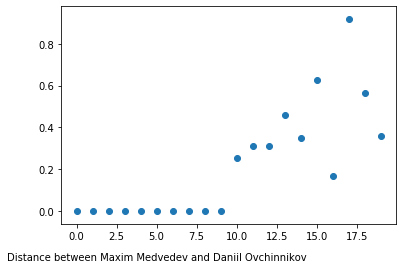

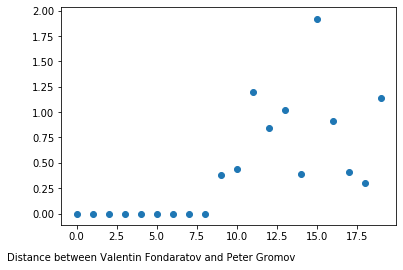

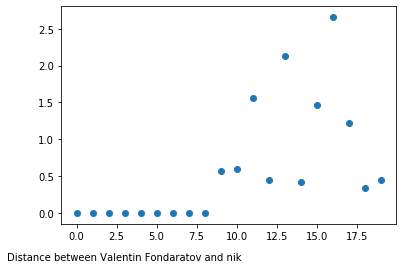

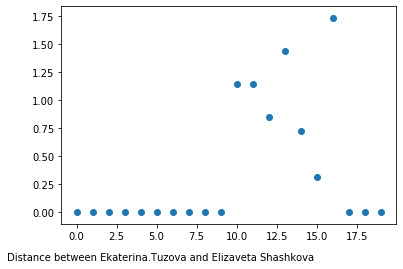

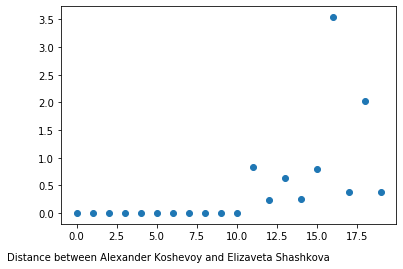

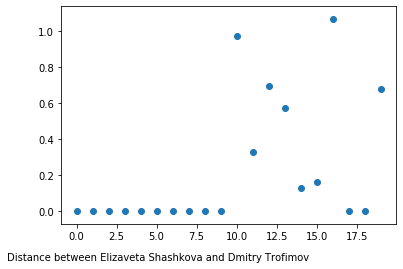

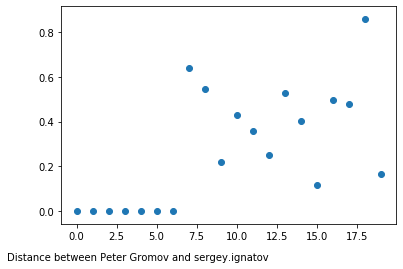

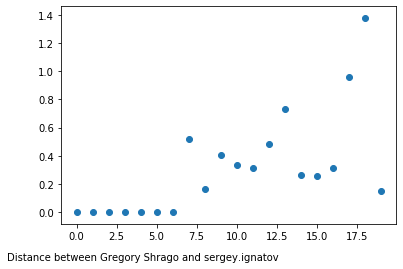

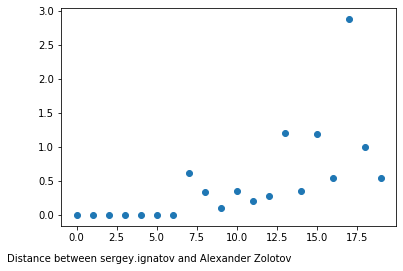

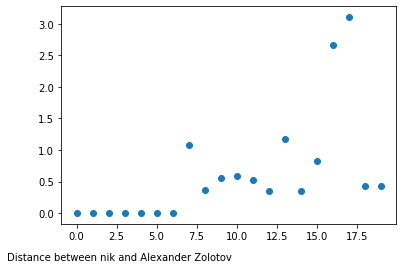

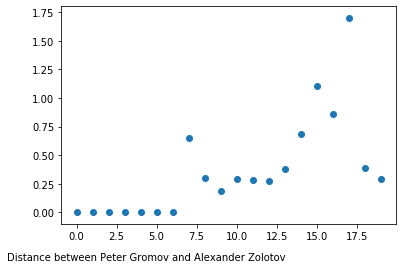

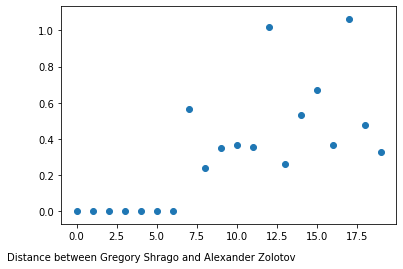

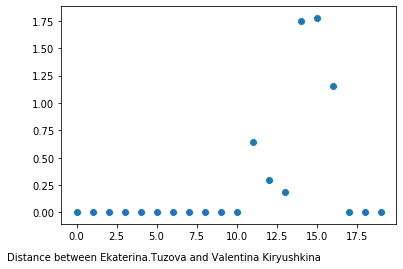

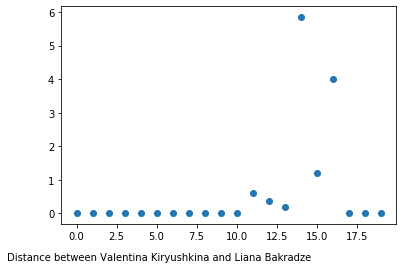

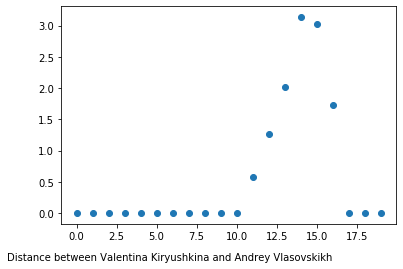

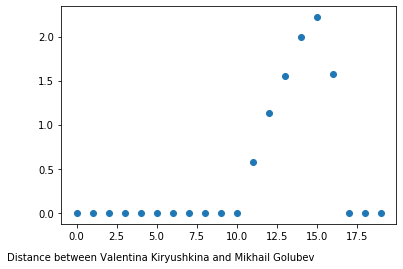

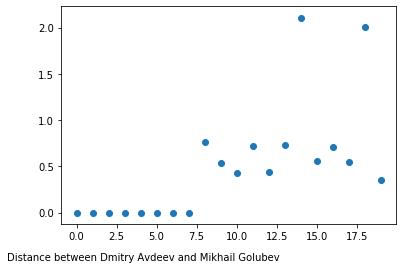

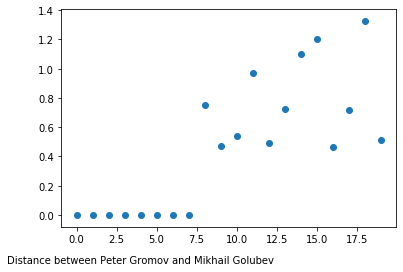

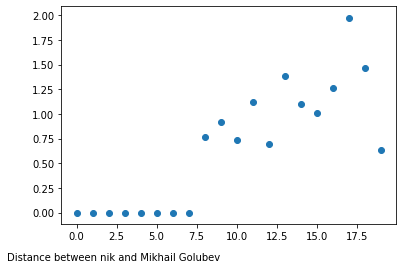

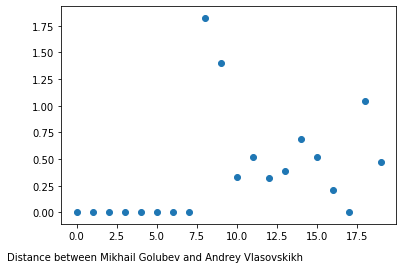

In [9]:
#POSITIVE  
pos_examples = []
pos_examples.append((78, 491))
pos_examples.append((56, 59))
pos_examples.append((56, 179))
pos_examples.append((27, 286))
pos_examples.append((114, 286))
pos_examples.append((286, 338))
pos_examples.append((59, 182))
pos_examples.append((88, 182))
pos_examples.append((182, 282))
pos_examples.append((179, 282))
pos_examples.append((59, 282))
pos_examples.append((88, 282))
pos_examples.append((27, 51))
pos_examples.append((51, 274))
pos_examples.append((51, 265))
pos_examples.append((51, 199))
pos_examples.append((68, 199))
pos_examples.append((59, 199))
pos_examples.append((179, 199))
pos_examples.append((199, 265))

for pe in pos_examples:
    show_distance_trend(pe[0], pe[1], "pos_{}_{}.pdf".format(pe[0], pe[1]))


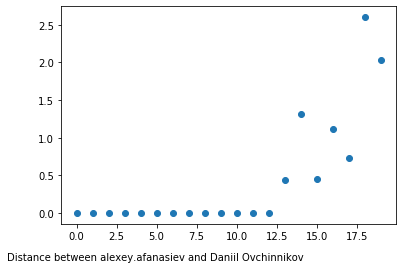

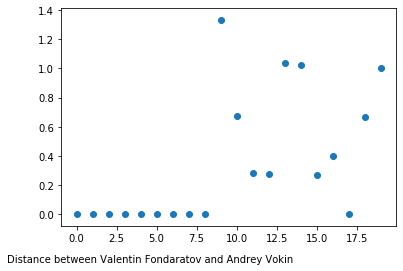

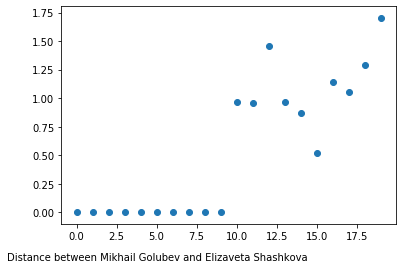

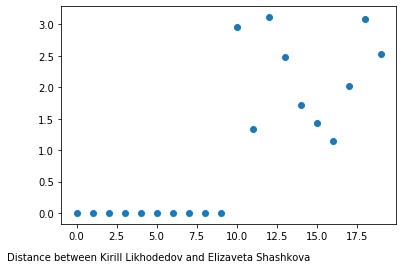

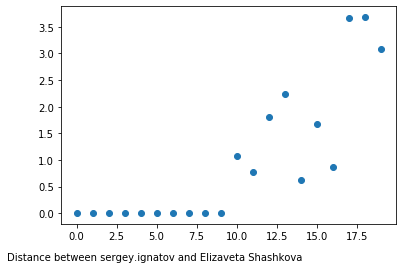

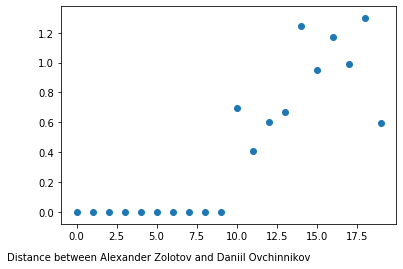

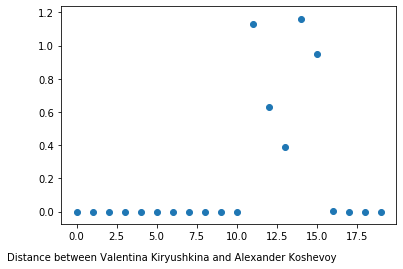

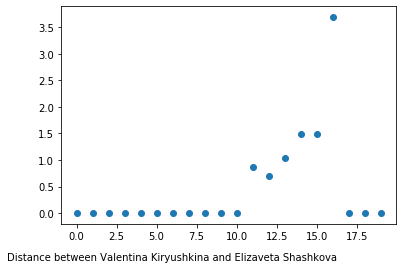

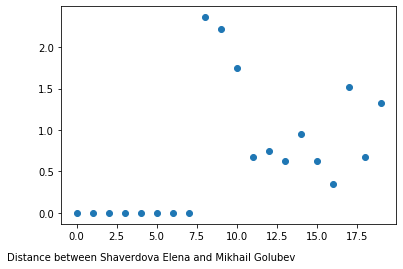

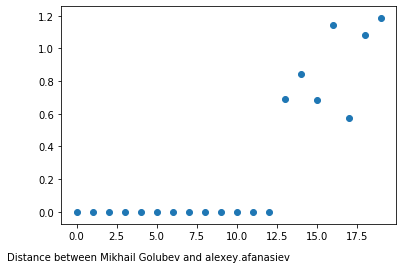

In [10]:
#NEGATIVE
neg_examples = []
neg_examples.append((240, 491))
neg_examples.append((56, 221))
neg_examples.append((199, 286))
neg_examples.append((228, 286))
neg_examples.append((182, 286))
neg_examples.append((282, 491))
neg_examples.append((51, 114))
neg_examples.append((51, 286))
neg_examples.append((73, 199))
neg_examples.append((199, 240))

for ne in neg_examples:
    show_distance_trend(ne[0], ne[1], "neg_{}_{}.pdf".format(ne[0], ne[1]))

In [16]:
def get_diff_distribution(trend_list):
    diffs = []
    for t in trend_list:
        diffs.append(get_diff(t))
    diff_values = []
    for d in diffs: 
        for val in d:
            if val is not None and val != 0:
                diff_values.append(val)
    return diff_values

def plot_distribution(dist):
    n_bins = 20
    plt.hist(dist, n_bins)


neg_trends = []
for ne in neg_examples:
    neg_trends.append(get_distance_trend(ne[0], ne[1]))

# print(neg_trends)
neg_diffs = get_diff_distribution(neg_trends)

pos_trends = []
for pe in pos_examples:
    pos_trends.append(get_distance_trend(pe[0], pe[1]))
    
pos_diffs = get_diff_distribution(pos_trends)

# all_diffs = get_diff_

# print(neg_diffs)
# plot_distribution(neg_diffs)
# plot_distribution(pos_diffs)

print(stats.mstats.describe(pos_diffs))
print(stats.mstats.describe(neg_diffs))

print(stats.normaltest(pos_diffs))
print(stats.normaltest(neg_diffs))

DescribeResult(nobs=array(212), minmax=(masked_array(data=-4.66290735,
             mask=False,
       fill_value=1e+20), masked_array(data=5.67806604,
             mask=False,
       fill_value=1e+20)), mean=0.032445917834911714, variance=0.9917539253215707, skewness=masked_array(data=-0.0036173,
             mask=False,
       fill_value=1e+20), kurtosis=7.767401517079486)
DescribeResult(nobs=array(91), minmax=(masked_array(data=-3.69110259,
             mask=False,
       fill_value=1e+20), masked_array(data=2.94896177,
             mask=False,
       fill_value=1e+20)), mean=0.14783741622245933, variance=0.8664612848337763, skewness=masked_array(data=-0.01092508,
             mask=False,
       fill_value=1e+20), kurtosis=3.222140329365753)
NormaltestResult(statistic=42.47386661125426, pvalue=5.982973135824519e-10)
NormaltestResult(statistic=12.259034495197987, pvalue=0.0021776319640666787)
Ks_2sampResult(statistic=0.08278042712004977, pvalue=0.7351918895933165)


In [17]:
print(stats.ks_2samp(neg_diffs, pos_diffs))

    

Ks_2sampResult(statistic=0.08278042712004977, pvalue=0.7351918895933165)
